In [1]:
# For data manipulation and analysis
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots appear in the notebook
%matplotlib inline


In [2]:

fraud = pd.read_csv("../data/raw/Fraud_Data.csv")

# Display the first 5 rows
fraud.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
# How many rows and columns?
fraud.shape


(151112, 11)

In [4]:
# Column names, data types, and non-null count
fraud.info()

# Check missing values per column
fraud.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [5]:
# Count duplicate rows
fraud.duplicated().sum()


np.int64(0)

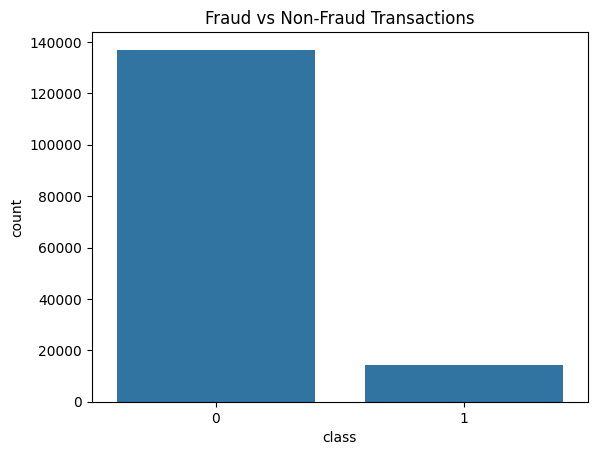

In [6]:
# Count fraud vs non-fraud
fraud['class'].value_counts()

# Plot the distribution
sns.countplot(x='class', data=fraud)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()


### Convert Time Columns to Datetime

In [7]:
# Convert signup_time and purchase_time to datetime format
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])

# Check the first few rows to confirm
fraud[['signup_time', 'purchase_time']].head()


,signup_time,purchase_time
0,2015-02-24 22:55:49,2015-04-18 02:47:11
1,2015-06-07 20:39:50,2015-06-08 01:38:54
2,2015-01-01 18:52:44,2015-01-01 18:52:45
3,2015-04-28 21:13:25,2015-05-04 13:54:50
4,2015-07-21 07:09:52,2015-09-09 18:40:53


### Create time_since_signup

In [8]:
# Calculate the time difference between signup and purchase in hours
fraud['time_since_signup'] = (fraud['purchase_time'] - fraud['signup_time']).dt.total_seconds() / 3600

# Preview the new column
fraud[['signup_time', 'purchase_time', 'time_since_signup']].head()


,signup_time,purchase_time,time_since_signup
0,2015-02-24 22:55:49,2015-04-18 02:47:11,1251.856111
1,2015-06-07 20:39:50,2015-06-08 01:38:54,4.984444
2,2015-01-01 18:52:44,2015-01-01 18:52:45,0.000278
3,2015-04-28 21:13:25,2015-05-04 13:54:50,136.690278
4,2015-07-21 07:09:52,2015-09-09 18:40:53,1211.516944


### Extract Hour and Day of Week

In [9]:
# Hour of day (0-23) when purchase occurred
fraud['hour_of_day'] = fraud['purchase_time'].dt.hour

# Day of week (0=Monday, 6=Sunday)
fraud['day_of_week'] = fraud['purchase_time'].dt.dayofweek

# Preview
fraud[['purchase_time', 'hour_of_day', 'day_of_week']].head()


,purchase_time,hour_of_day,day_of_week
0,2015-04-18 02:47:11,2,5
1,2015-06-08 01:38:54,1,0
2,2015-01-01 18:52:45,18,3
3,2015-05-04 13:54:50,13,0
4,2015-09-09 18:40:53,18,2


### Quick Visualization

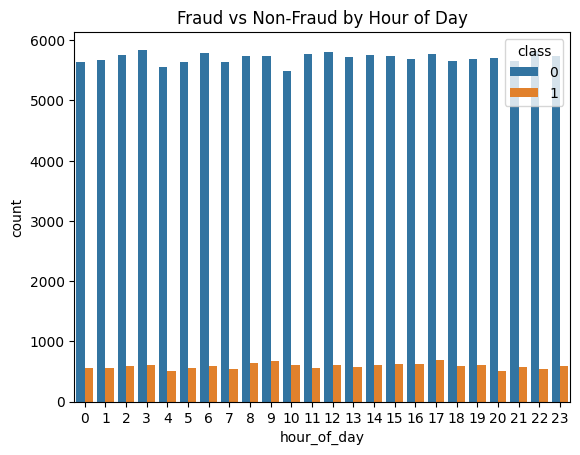

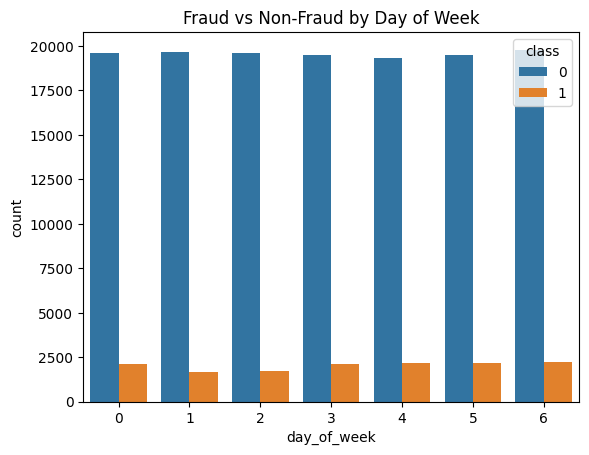

In [10]:
# Plot fraud by hour of day
sns.countplot(x='hour_of_day', hue='class', data=fraud)
plt.title("Fraud vs Non-Fraud by Hour of Day")
plt.show()

# Plot fraud by day of week
sns.countplot(x='day_of_week', hue='class', data=fraud)
plt.title("Fraud vs Non-Fraud by Day of Week")
plt.show()


### IP-to-Country Mapping

In [11]:
# Load IP address to country mapping
ip_map = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

# Preview the data
ip_map.head()


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Convert IP Addresses to Integers

In [14]:
import socket
import struct
import numpy as np

def ip_to_int(ip):
    try:
        # Remove extra spaces if any
        ip = str(ip).strip()
        # Skip if empty or invalid
        if ip == '' or ip.lower() == 'nan':
            return np.nan
        return struct.unpack("!I", socket.inet_aton(ip))[0]
    except:
        return np.nan


### Convert Mapping IPs to Integers

In [15]:
# Transaction dataset
fraud['ip_int'] = fraud['ip_address'].apply(ip_to_int)

# Mapping dataset
ip_map['lower_int'] = ip_map['lower_bound_ip_address'].apply(ip_to_int)
ip_map['upper_int'] = ip_map['upper_bound_ip_address'].apply(ip_to_int)


In [16]:
print("NaNs in transaction IPs:", fraud['ip_int'].isna().sum())
print("NaNs in IP mapping:", ip_map['lower_int'].isna().sum(), ip_map['upper_int'].isna().sum())


NaNs in transaction IPs: 151112
NaNs in IP mapping: 138846 0


In [17]:
fraud['country'] = 'Unknown'


In [19]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_since_signup,hour_of_day,day_of_week,ip_int,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,1251.856111,2,5,NaN,Unknown
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,4.984444,1,0,NaN,Unknown
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,0.000278,18,3,NaN,Unknown
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,136.690278,13,0,NaN,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,1211.516944,18,2,NaN,Unknown


### Select Features & Target

In [20]:
# Target variable
y = fraud['class']

# Drop columns we should NOT use for training
X = fraud.drop(columns=[
    'class',
    'signup_time',
    'purchase_time',
    'ip_address',   # unusable
    'ip_int',       # unusable
    'country'       # all Unknown
])

X.head()


,user_id,purchase_value,device_id,source,browser,sex,age,time_since_signup,hour_of_day,day_of_week
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,1251.856111,2,5
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,4.984444,1,0
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,0.000278,18,3
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,136.690278,13,0
4,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,1211.516944,18,2


### Separate Numerical & Categorical Columns

In [21]:
# Numerical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Categorical columns
cat_cols = X.select_dtypes(include=['object']).columns

print("Numerical columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))


Numerical columns: ['user_id', 'purchase_value', 'age', 'time_since_signup']
Categorical columns: ['device_id', 'source', 'browser', 'sex']


Identify High-Cardinality Columns

In [24]:
for col in cat_cols:
    print(col, fraud[col].nunique())


device_id 137956
source 3
browser 5
sex 2


Encoding Categoricals

In [25]:
from sklearn.preprocessing import LabelEncoder

X_final = X.copy()
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_final[col] = le.fit_transform(X_final[col].astype(str))
    label_encoders[col] = le

X_final.head()


,user_id,purchase_value,device_id,source,browser,sex,age,time_since_signup,hour_of_day,day_of_week
0,22058,34,89215,2,0,1,39,1251.856111,2,5
1,333320,16,24078,0,0,0,53,4.984444,1,0
2,1359,15,131216,2,3,1,53,0.000278,18,3
3,150084,44,3977,2,4,1,41,136.690278,13,0
4,221365,39,68757,0,4,1,45,1211.516944,18,2


Scale Numerical Columns

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_final[num_cols] = scaler.fit_transform(X_final[num_cols])


Train-Test Split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Check class distribution

In [28]:

class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

pd.DataFrame({
    "Count": class_counts,
    "Percentage (%)": class_percent.round(2)
})

,Count,Percentage (%)
class,,
0,136961,90.64
1,14151,9.36


Train Baseline Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

log_reg.fit(X_train, y_train)


c:\Users\THINKPAD\Desktop\10_Academy\Week_5\fraud-detection\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\THINKPAD\Desktop\10_Academy\Week_5\fraud-detection\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [30]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]


In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9530    0.6365    0.7632     27393
           1     0.1652    0.6965    0.2671      2830

    accuracy                         0.6421     30223
   macro avg     0.5591    0.6665    0.5152     30223
weighted avg     0.8793    0.6421    0.7168     30223



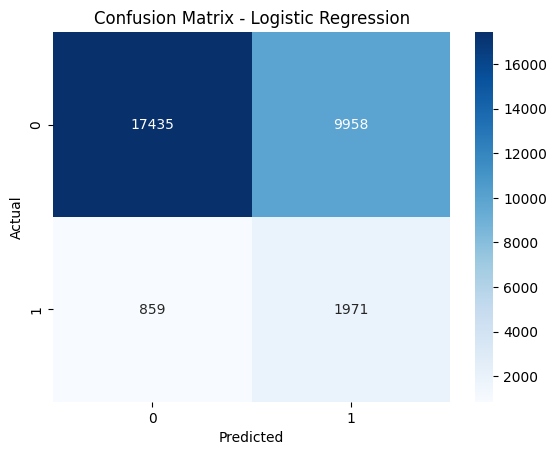

In [33]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [34]:
from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC:", round(pr_auc, 4))


PR-AUC: 0.4957
